<div style="text-align:right"><i>Peter Norvig<br>May 2023</div>
    
# The Diamond Game: A Probability Puzzle

Puzzle master [**Wei-Hwa Huang**](https://en.wikipedia.org/wiki/Wei-Hwa_Huang) poses this problem (reworded by me): 
    
*You are playing a game where a merchant has a stockpile of bags for sale. Each bag contains an unknown number of diamonds.  You can **buy** a randomly selected bag for 12 coins, look in the bag to see how many diamonds there are, and immediately decide whether to **keep it**, or **sell it back** for 11 coins.  You can also (as many times as you want and at no cost) **peek** at a random bag and count the diamonds, without the option to buy.  What is a good **strategy** for **maximizing** the number of diamonds in the bags you keep?*
    
In this notebook I solve the problem and along the way demonstrate:
- How to reason with probability.
- How to compute the optimal strategy for a game like this.
- How to use data visualizations to better understand the results.
    
# The main concepts
    
- **Strategy**: In general, a strategy for a game is a policy for choosing an action, in each possible **situation**. 
- **Actions**: The actions are to **peek** at or **buy** a bag, and after buying to **keep** the bag or **sell** it back, and finally to **stop** the game. 
- **Situations**: A situation consists of (1) the number of coins you have, (2) if you just bought a bag, the number of diamonds in it, and (3) what you have learned about the distribution of diamonds from peeking. The situation does not include the number of diamonds you have already bought, because that information is irrelevant to what your best strategy should be; you are always trying to get more diamonds, regardless of how many you already have.
- **Good strategy**: Here's what I think a good strategy should do:
    - **Use the coins**: The goal is to maximize diamonds, not coins, so don't **stop** until you have 11 or fewer coins (not enough to buy a bag). With 12 coins, buy a bag and keep it no matter what, because selling it back won't give you enough coins to buy another bag.
    - **Peek first**: If you're going to do *K* peeks eventually, it is always better to do all *K* peeks before any buys, so they can inform your future keep/sell choices. This is because peeks are free. If peeks had a cost, a good strategy would consider peeks that are contingent on the result of previous peeks and buys. Once we accept the "use the coins" and "peek first" ideas, the remaining action choices are just **keep** or **sell**.
    - **Maximize expected diamonds**: With 13 coins, buy a bag. Suppose it has *d* diamonds. Keep it if you think *d* is more than what you'd expect to get from selling it back and buying a different bag.  With 14 or more  you have to think ahead, considering the value of keeping or selling on this turn as well as on subsequent turns. No strategy can *guarantee* a maximal number of diamonds, because the number you get depends in part on random luck of the draw. Instead of a guarantee, we can evaluate a strategy by its  [**expected value**](https://en.wikipedia.org/wiki/Expected_value): the expected number of diamonds obtained starting from a given situation, averaged over all possible random selections of bags from the stockpile. 
- **Probability distribution**: Bags can be represented as a collection of integer diamond counts: which counts are possible, and how often did each occur. This is called a [**discrete probability distribution**](https://en.wikipedia.org/wiki/Probability_distribution#Discrete_probability_distribution).
- **Stockpile**: By default, I'll say a stockpile is 10,000 bags with mean 100 diamonds per bag.
- **Peeks**: By default, a player peeks at 1,000 bags. (That should be plenty, but I'll test to make sure.)
        
# Preliminaries
    
Let's get these out of the way first: imports of necessary modules, and some constants: 

In [1]:
from typing     import *
from statistics import mean, stdev
import matplotlib.pyplot as plt
import functools
import random

BUY  = 12     # How many coins a bag costs
SELL = 11     # How many coins you get from selling a bag back
MEAN = 100    # Average number of diamonds in a bag
N    = 10_000 # Default number of bags in the merchant's stockpile
K    = 1_000  # Default number of peeks at the stockpile

cache = functools.lru_cache(None) # Decorator

random.seed(42) # For reproducability

# Discrete probability distributions

There are two different collections of bags that we need to represent:
- The merchant's stockpile of bags.
- The bags that the player has peeked at.

In both cases we need to know the number of diamonds in each bag, so essentially we want to represent a collection of integers, and how often each of those integers appears. I implement this with the class `ProbDist`, a subclass of Python's `Counter` class, that works as follows:
- `P = ProbDist([100, 101, 100])` (or `P = ProbDist({100: 2, 101: 1})`) makes a distribution `P` with 3 samples.
- `P(d)` gives the *probability* of `d` diamonds (e.g. `P(100) == 2/3`).
- `P[d]` gives the *count* of `d` diamonds (e.g. `P[100] == 2`).
- `P` is *hashable*, so that it can be passed to functions with a `cache` decorator. Caching is crucial for efficiency.
- The attributes `P.n, P.μ, P.σ` give the total count, mean, and standard deviation of the values in `P`, respectively.
- The `__str__` method gives an informative description of the distribution, including a descriptive `name`.


In [2]:
class Hashable:
    """A mixin that hashes objects based on their identity."""
    def __hash__(self): return id(self)
    def __eq__(self, other): return self is other

class ProbDist(Hashable, Counter):
    """A discrete probability distribution, mapping values to frequencies."""
    def __init__(self, samples: Union[Iterable, Mapping], name='ProbDist'):
        "`samples` can be either an iterable of values, or a {val: count} mapping."
        super().__init__(samples)
        values = list(self.elements())
        self.__dict__.update(μ=mean(values), σ=stdev(values), n=len(values), name=name)
    def __call__(self, d) -> float: return self[d] / self.n
    def __str__(self) -> str: return f'{self.name}[μ={self.μ:.1f}, σ={self.σ:.1f}, n={self.n:,d}]'

Here's an example of building a probability distribution, `P`, from five values, and making some assertions about it:

In [3]:
P = ProbDist([108, 92, 108, 100, 92])

assert P[108]  == 2   # number of times 108 occurs
assert P(108)  == 2/5 # probability of 108
assert P.n     == 5   # total number of samples in the distribution
assert P.μ     == 100 # mean of the samples
assert P.σ     == 8   # standard deviation of the samples
assert dict(P) == {108: 2, 92: 2, 100: 1} 
assert repr(P) == 'ProbDist({108: 2, 92: 2, 100: 1})'
assert str(P)  == 'ProbDist[μ=100.0, σ=8.0, n=5]'

I will define the function `normal` to create a stockpile of bags that will have a roughly normal (Gaussian) distribution. Then I will define `peek` to peek at some of the bags in the stockpile:

In [4]:
def normal(σ, μ=MEAN, n=N) -> ProbDist:
    """A ProbDist of `n` integers from a Normal distribution with mean `μ` and standard deviation `σ`."""
    values = [max(0, round(random.gauss(μ, σ))) for _ in range(n)]
    return ProbDist(values, 'normal')

def peek(stockpile: ProbDist, k=K) -> ProbDist:
    """A ProbDist formed by peeking at k values sampled randomly from stockpile."""
    values = random.choices(list(stockpile.elements()), k=k)
    return ProbDist(values, stockpile.name + '_peek')

We see that a `peek` at 1,000 bags does a good job of capturing the statistics of a stockpile:

In [40]:
stock1 = normal(σ=1)
peek1 = peek(stock1)

In [41]:
print(stock1)

normal[μ=100.0, σ=1.0, n=10,000]


In [42]:
print(peek1)

normal_peek[μ=100.0, σ=1.0, n=1,000]


In [8]:
stock1.most_common()

[(100, 3808),
 (99, 2476),
 (101, 2388),
 (98, 611),
 (102, 598),
 (103, 58),
 (97, 55),
 (104, 3),
 (96, 3)]

In [9]:
peek1.most_common()

[(100, 390), (99, 251), (101, 237), (98, 61), (102, 54), (103, 4), (97, 3)]

# Strategies

We previously explained that it best to do all the peeks first, and to continue buying bags until the coins are exhausted. So we'll assume that all strategies automatically do that, and we're left with the task of making **keep**/**sell** choices. I will use two conventions:
- A **strategy** is a function, `strategy(c, d)`, that returns  `'keep'` if a player with `c` coins should keep a bag with `d` diamonds, and otherwise returns `'sell'`. 
- A **strategy maker** is a function that is passed a distribution of peeked-at bags and returns a strategy function.

For example, `cutoff_strategy` is a strategy maker such that `cutoff_strategy(peeks, 0.95)` returns a strategy function that keeps all bags with at least 95% of the mean number of diamonds in `peeks`. (Also, if it started with exactly BUY coins, it keeps the bag, because selling it back would not yield enough coins to buy another bag.)

In [10]:
Action   = Literal['keep', 'sell']      # The two possible actions
Strategy = Callable[[int, int], Action] # strategy(coins, diamonds) -> 'keep' | 'sell'

def cutoff_strategy(peeks: ProbDist, ratio=1.0) -> Strategy:
    """Strategy to keep all bags with `ratio * P.μ` or more diamonds. 
    Also keep a bag if selling it back would not yield enough coins to buy another bag."""
    cutoff = ratio * peeks.μ
    def strategy(c: int, d: int) -> Action: 
        return 'keep' if (c == BUY or d >= cutoff) else 'sell'
    strategy.__name__ = f'cutoff_{cutoff:.0f}' # Give the strategy a descriptive name
    return strategy

Here are some examples of a cutoff strategy deciding what action to take:

In [43]:
strategy = cutoff_strategy(peek1, 0.95)  # A strategy to keep bags at least 95% of the mean of peek1

assert strategy(13,  92)  == 'sell'      #  92 is below the cutoff; sell it back
assert strategy(23, 103)  == 'keep'      # 103 is above the cutoff; keep it

# Expected value

I'll define $E(P, \textit{strategy}, c)$ to be the expected number of diamonds that can be bought with $c$ coins, from a stockpile with distribution $P$, when the player follows the given $\textit{strategy}$. The expected value is 0 if we don't have enough coins to buy any bags, and otherwise is the probability-weighted average, over all possible bags, of the expected value of the result of either keeping or selling back the bag, depending on what the strategy says to do.  That can be written as:


$$E(P, \textit{strategy}, c) = \sum_{d \in P} P(d) \left\{ \begin{array}{ l l }
    0 &  \textbf{if } c < 12 \\
    E(P, \textit{strategy}, c - 12) + d   &  \textbf{if } \textit{strategy}(c, d) = \textit{keep} \\
    E(P, \textit{strategy}, c - 12  + 11) &  \textbf{if } \textit{strategy}(c, d) = \textit{sell}
  \end{array}\right.$$
  
Our game is simple enough that it is feasible  to do an exact expected value calculation, as long as we remember to cache intermediate results for efficiency:

In [12]:
@cache
def E(P: ProbDist, strategy: Strategy, c: int) -> float:
    """The expected number of diamonds that can be bought with `c` coins using `strategy`,
    when the stockpile of bags has distribution `P`.""" 
    return (0 if c < BUY else
            sum(P(d) * (E(P, strategy, c - BUY) + d if strategy(c, d) == 'keep' else 
                        E(P, strategy, c - BUY + SELL)) 
                for d in P))

This works because each recursive call reduces the number of coins, and when we get down to fewer than 12 coins, the expected value is always zero. If this was not the case (say, if you could have a negative balance of coins and still continue the game) then this computation of $E$ would lead to an infinite loop.

# Optimal strategy

For any game, the optimal strategy is to *take the action that leads to the highest expected value*. That may sound trivial or circular: "the best strategy is to choose the best action." But it is actually neither trivial nor circular, and can be implemented as follows: 

In [13]:
def optimal_strategy(peeks: ProbDist) -> Strategy:
    """Strategy to take the action (keep or sell) that leads to the highest expected value."""
    def optimal(c: int, d: int) -> Action:
        return 'keep' if E(peeks, optimal, c - BUY) + d > E(peeks, optimal, c - BUY + SELL) else 'sell'
    return optimal

One subtle but important point: if we want to know the *true* expected value of a situation, we would call `E(c, stockpile, strategy)`. That's easy enough for us to do as outside observers of the game. But a player *in* the game does not have access to the stockpile; all they have is an *estimate* of the stockpile distribution, gained from peeks.  We will see that usually the estimation is quite good.

Here we see the optimal strategy in action:

In [14]:
stock10 = normal(10)               # A stockpile with standard deviation 10 (and mean 100)
peek10  = peek(stock10)            # A probability distribution formed by peeking at some bags

optimal = optimal_strategy(peek10) # The optimal strategy with respect to peek10
assert 99 < peek10.μ < 101         # The mean of peek10 should be somewhere around 100
assert  9 < peek10.σ <  11         # The standard ddeviation of peek10 should be somewhere around 10
assert optimal(13,  98) == 'sell'  # sell back because we expect about 100 on the next buy
assert optimal(13, 103) == 'keep'  # keep because we expect about 100 on the next buy
assert optimal(23, 103) == 'sell'  # 103 is an above average bag, but we have 10 chances to do better; sell it
assert optimal(23, 115) == 'keep'  # Even with 10 more chances, it is tough to beat a bag with 115 diamonds
assert optimal(12,  50) == 'keep'  # keep because if we sold we couldn't buy another bag

We can use the strategy to play a random instance of the game:

In [44]:
def play(strategy, coins: int, stockpile: ProbDist, verbose=True) -> List[int]:
    """Play a game using `strategy` and return the list of bags kept. Optionally print each action."""
    bags = list(stockpile.elements())
    kept = [] # List of bags kept
    while coins >= BUY:               # While you have enough coins to buy a bag:
        coins -= BUY                  # Buy a bag
        bag = random.choice(bags)     # Count the diamonds in the bag
        action = strategy(coins, bag) # Decide whether to keep it or sell it back
        if action == 'keep':
            kept.append(bag)
        else:
            coins += SELL
        if verbose: 
            print(f'{bag:3d} diamond bag: {action} it (total: {sum(kept):3d} diamonds and {coins:3d} coins.')
    return kept

In [45]:
play(optimal_strategy(peek10), 95, stock10)

102 diamond bag: sell it (total:   0 diamonds and  94 coins.
105 diamond bag: keep it (total: 105 diamonds and  82 coins.
 92 diamond bag: sell it (total: 105 diamonds and  81 coins.
112 diamond bag: keep it (total: 217 diamonds and  69 coins.
100 diamond bag: sell it (total: 217 diamonds and  68 coins.
 89 diamond bag: sell it (total: 217 diamonds and  67 coins.
109 diamond bag: keep it (total: 326 diamonds and  55 coins.
106 diamond bag: keep it (total: 432 diamonds and  43 coins.
112 diamond bag: keep it (total: 544 diamonds and  31 coins.
111 diamond bag: keep it (total: 655 diamonds and  19 coins.
 99 diamond bag: keep it (total: 754 diamonds and   7 coins.


[105, 112, 109, 106, 112, 111, 99]

**We've solved the problem!** 

We could stop here, but ...

___

# Visualizing a Strategy

I have some remaining questions! 

We have *defined* the optimal strategy, but do we *understand* it? In exactly which situations should we keep a bag and when should we sell it back? What's a concise intuitive explanation for these results? Here's some code that might lead to some understanding:

In [17]:
plt.rcParams["figure.figsize"] = (14, 6)

COINS = range(12, 121) # Range of coin values to examine

def plot_strategy(P: ProbDist, strategy):
    """Plot (coins, diamonds) points for which strategy(c, d) == 'sell'."""
    points = [(c, d) for c in COINS for d in range(min(P), max(P) + 1) 
              if strategy(c, d) == 'sell']
    plt.scatter(*transpose(points), marker='.', label=strategy.__name__)
    decorate(title=f'When to sell back with {strategy.__name__} strategy on {P}')
    
def decorate(title, xticks=COINS[::BUY], xlabel='coins', ylabel='diamonds'):
    """Decorate the plot with title, grid lines, ticks, and labels."""
    plt.grid(True); plt.xticks(xticks)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    
def transpose(matrix): return zip(*matrix)

The plot below looks at situations where the x-axis lists the number of coins you have before you buy a bag, and the y-axis lists the number of diamonds in the bag you bought. A blue dot at position (x, y) means that the optimal strategy is to sell the bag back in that situation. This is the *true* optimal strategy for `stock10`, obtained by having exact knowledge of the stockpile, something that a player could never obtain exactly.

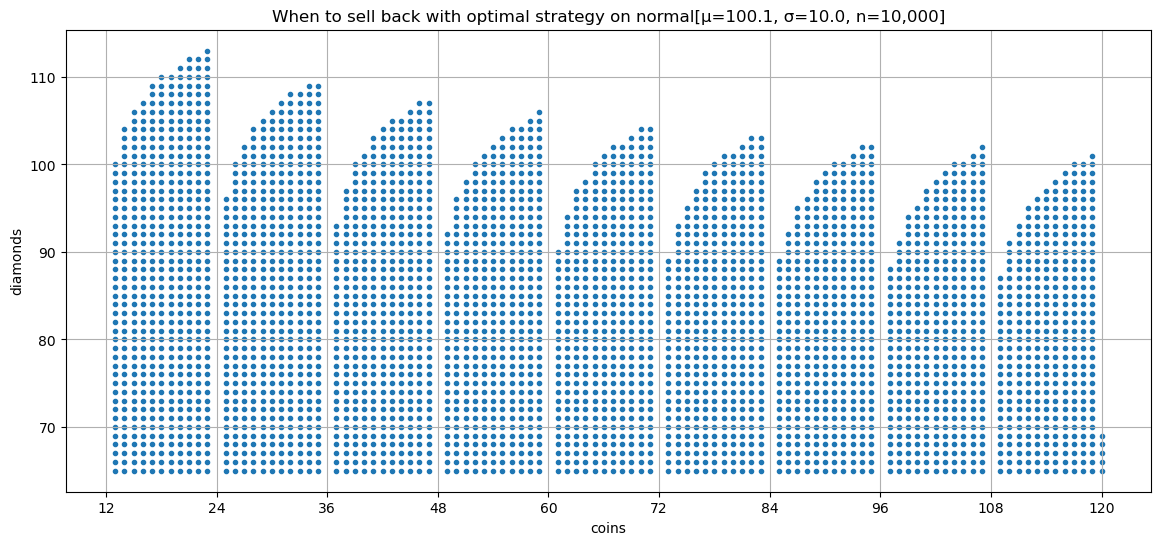

In [18]:
plot_strategy(stock10, optimal_strategy(stock10))

We notice three things about this plot:
- It is made out of sawtooths.
- The edge of each sawtooth goes up as the number of coins mod 12 goes up. When you have an exact multiple of 12 coins, it is (almost always) best to keep the bag you just bought, no matter how bad the bag.  For example, with 24 coins it is always better to buy and keep 2 bags than to sell one back and be left with only enough coins to keep 1 bag. With each extra coin from 25 to 35, we can afford to be more picky, and the bag values that we will sell back increase, from 96 up to 109.  (The first time that we see a multiple of 12 where it is better to sell a bag back is with 120 coins, and then only for bags with 69 or fewer diamonds. Such bags are more than 3 standard deviations from the mean, so they occur less than 0.5% of the time.)
- The height of each sawtooth goes down as the number of coins increases. I think that is because with, say, 23 coins you know you have 11 chances to buy and sell back the next bag, so you can afford to reject pretty good bags, such as 100 diamonds. With 119 coins you also have 11 extra coins that can be used to buy and sell back, but you need to allocate them over nine different bags that you will be keeping, so you don't want to use them all up right away.

# Evaluating a strategy with a metric

It would be nice to have a **single metric** to evaluate how well a strategy does. In the quest to find such a metric, the first question is "how well a strategy does *what*?" One answer is "how well it gains diamonds, on average, starting with various numbers of coins." I'll define the function `metric` to do that. It returns the average number of diamonds per 12 coins, averaged over all starting numbers in the argument `coins`:

In [19]:
def metric(strategy, P, coins=COINS) -> float:
    """How many diamonds does the strategy get per 12 coins, averaged over all `coins`."""
    return mean(E(P, strategy, c) * BUY / c for c in coins)

In [20]:
optimal10 = optimal_strategy(peek10)
metric(optimal10, stock10)

94.40155233086679

Since the mean of `stock10` is very close to 100, you might be surprised to see that the  optimal strategy gets considerably less than that; does that mean something is wrong? ***No***–it means that when you start with a number of coins that has a non-zero remainder mod 12, you won't be able to buy a full additional bag, and by default the average takes into account all remainders mod 12.  We can look at just the coins that are multiples of 12; that should give a metric very near 100:

In [21]:
metric(optimal10, stock10, range(12, 100, 12))

100.05930000000001

And we can look at just the coins that are equal to 11 mode 12; that should give a lower value:

In [22]:
metric(optimal10, stock10, range(11, 100, 12))

74.26480822105012

# Visualizing Expected Values

The function `plot_E` below allows us to plot the expected value for a strategy as a function of the number of coins. We can compare different stockpiles, strategies, and/or numbers of peeks.  The function produces two plots: one that displays the expected total number of diamonds as a function of the number of coins, and one that displays the expected number of diamonds per 12 coins. (You can think of the second plot as being the same as the first, but rotated so that the x-axis parallels the values where the number of coins mod 12 is zero.)

In [23]:
def plot_E(stockpiles: Iterable[ProbDist], strategy_fns=[optimal_strategy], 
           ks=[K], coins=COINS, divide=False):
    """Plot the expected number of diamonds for different stockpiles, strategies, and coins."""
    peeks = {(stock, k): peek(stock, k) for stock in stockpiles for k in ks} # precompute peeks
    for per_coins in ('', ' per 12 coins'):
        for k in ks: # k is the number of peeks
            for stock in stockpiles:
                for strategy_fn in strategy_fns:
                    strategy = strategy_fn(peeks[stock, k])
                    diamonds = [E(stock, strategy, c) * ((BUY / c) if per_coins else 1)
                                for c in coins]
                    m = metric(strategy, stock, coins)
                    label = f'{m:.1f}♦︎ {strategy.__name__}({peeks[stock, k]})'
                    plt.plot(coins, diamonds, 'o:', label=label)
        decorate(title='Expected number of diamonds' + per_coins, xticks=coins[::12])
        plt.legend(); plt.show()

We start with plots showing the expected number of diamonds obtained by the optimal strategy with 1,000 peeks at the `stock10` stockpile:

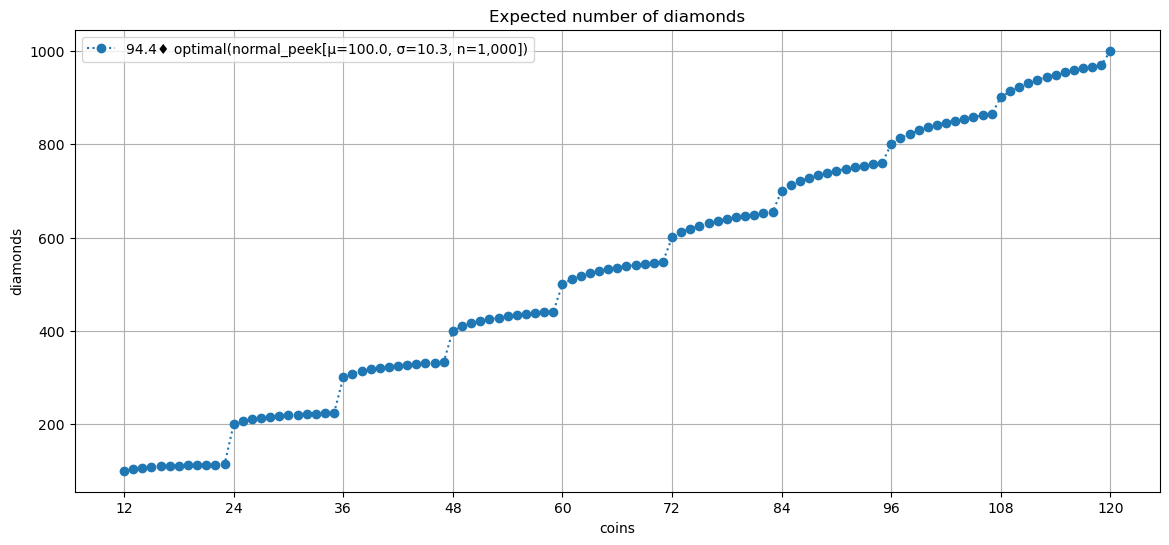

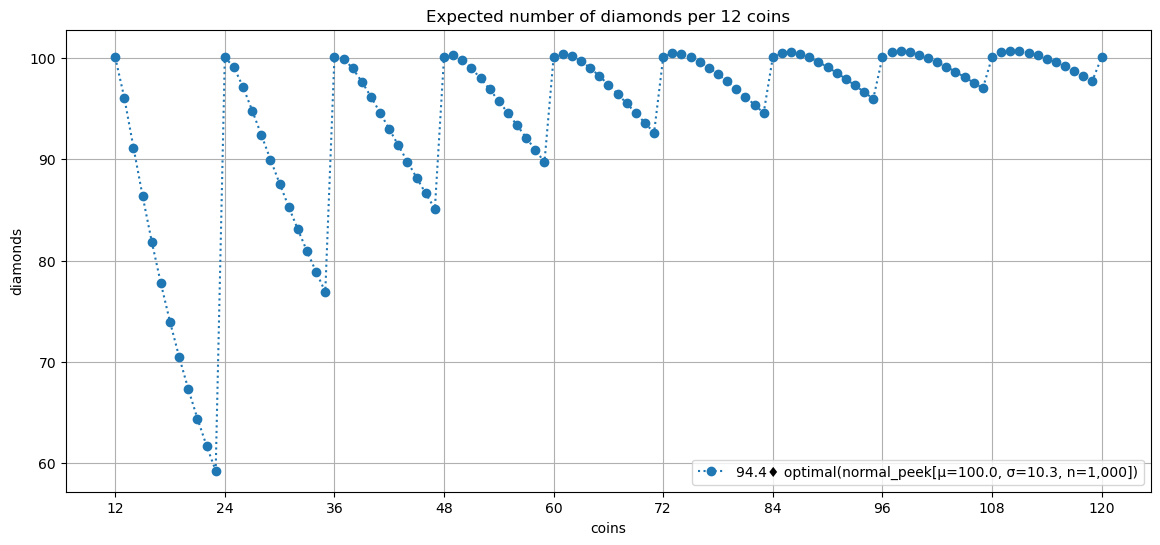

In [24]:
plot_E([stock10])

You can see that there are big jumps in expected return when the coins reach a multiple of 12, which correspond to being able to buy one more bag. Basically, the strategy with 12*b* coins is: "buy *b* bags, and keep them, no matter what, giving you an expected total of 100*b* diamonds, or 100 diamonds per 12 coins." (There are some exceptions to this rule.) 

In between the jumps, the top plot shows gradual increases in total expected diamonds; that's because with each additional coin, we have one more opportunity to sell back a bad bag and hope to get a better one.  But the expected number of diamonds per 12 coins (bottom plot) mostly decreases, because the return from the extra opportunities is small. We do see a few slight increases: the diamonds per 12 coins is slightly greater with 110 coins (9 bags plus two extra tries) than it is with 108 coins.

The expected value plots and the strategy plot tell the same story in two different ways: as we get more coins above a multiple of 12, we become pickier and sell back more bags; this leads to a higher expectation for the bags we keep and thus for our total expected value.

# The effect of standard deviation in the stockpile

Here is a plot comparing stockpiles with standard deviations of 33, 10, and 1: 

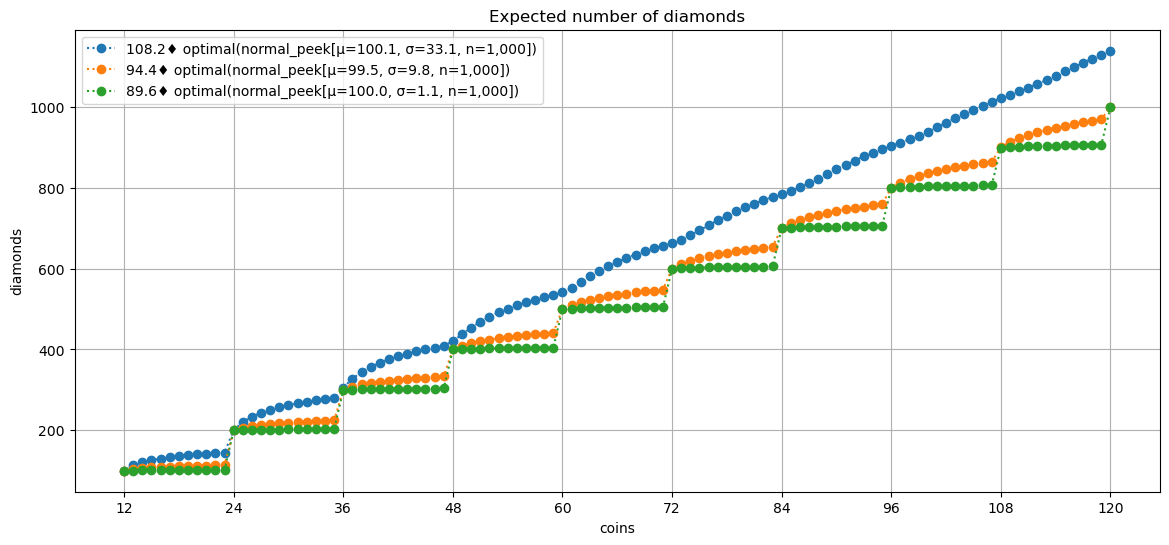

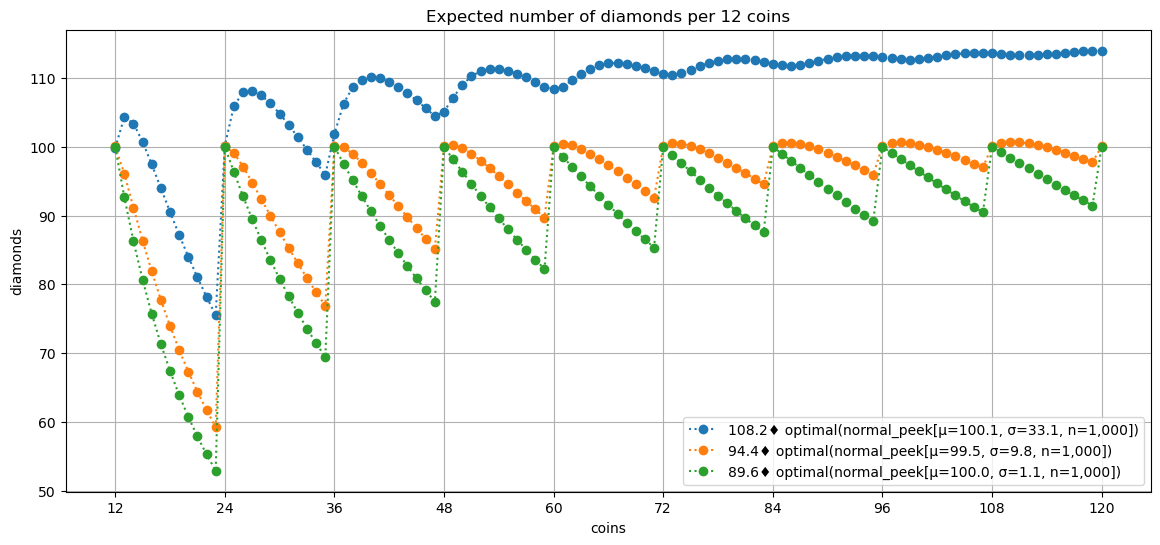

In [25]:
stock33 = normal(33) # Stockpile with standard deviation about 33
plot_E([stock33, stock10, stock1])

We see that with standard deviation 1 or 10, we can't get very far above 100 diamonds per 12 coins. But with standard deviation 33, the gamble of selling a bag back and buying another starts to really pay off, and we end up with over 110 diamonds per 12 coins. 

Below is the strategy plot for the optimal strategy on `stock33`. Note that with 12 coins the strategy is still to keep any bag but with multiples of 12 coins starting with 24 there are bag values that will be sold back, even though that means we will end up with one less bag.

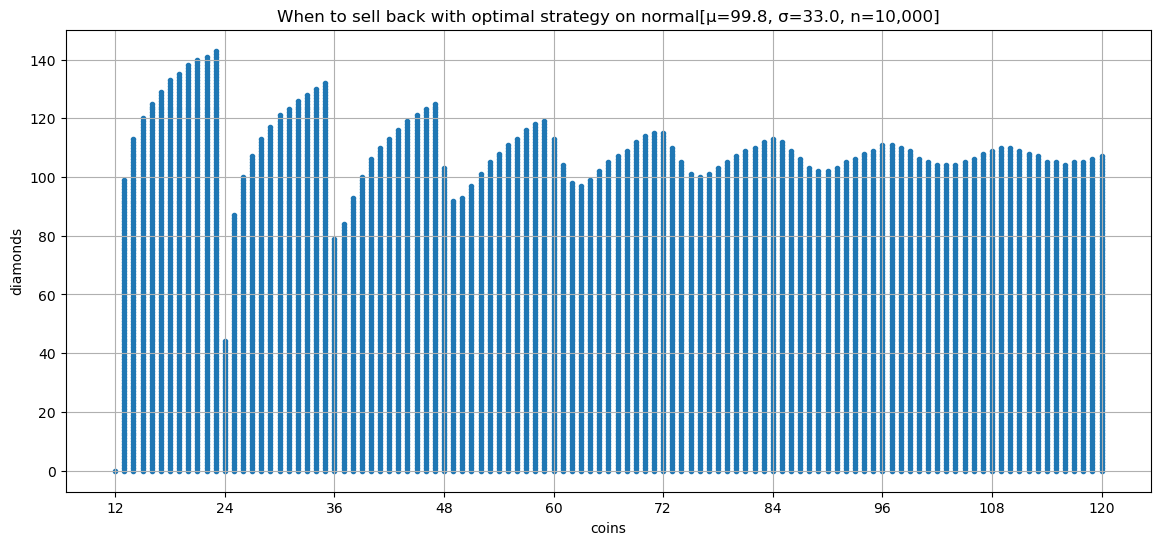

In [26]:
plot_strategy(stock33, optimal_strategy(stock33))

# The effect of stockpile distribution shape

The merchant's stockpile might bear no resemblance to a normal distribution. In this section I compare three stockpile distributions with very different shapes: a normal distribution, a uniform distribution, and a bimodal distribution that is the sum of two normal distributions. The three distributions have (roughly) the same mean and standard deviation. 

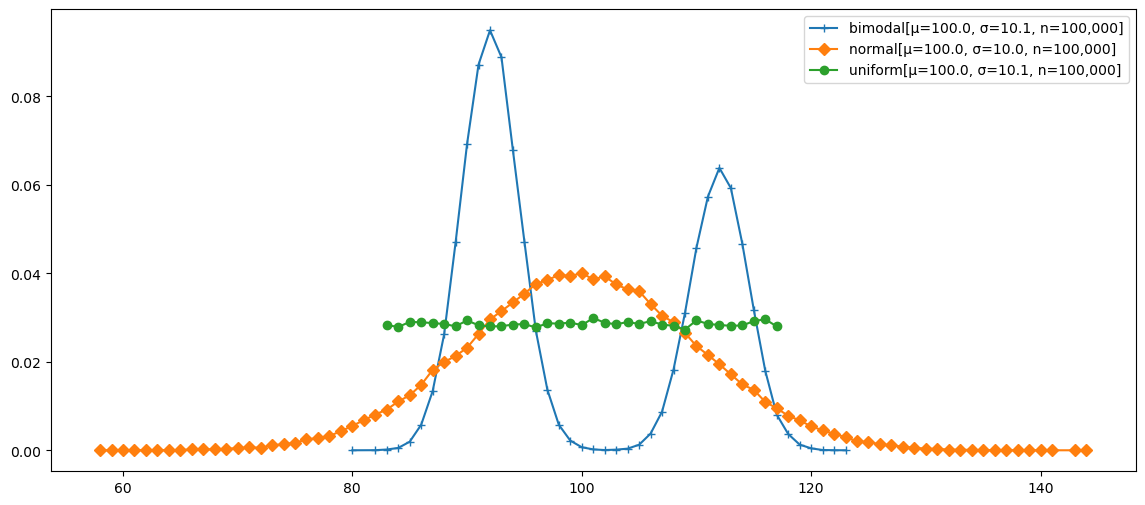

In [27]:
def uniform(μ=MEAN, semiwidth=15, n=N) -> ProbDist: 
    """A ProbDist of n integers chosen uniformly from μ ± semiwidth."""
    values = [random.randint(μ - semiwidth, μ + semiwidth) for _ in range(n)]
    return ProbDist(values, 'uniform')

def plot_shapes(shapes: Iterable[ProbDist]):
    """Plot the shapes of some probability dsitributions."""
    markers = iter('+DosP*xX')
    for P in shapes:
        X = sorted(P)
        plt.plot(X, [P(x) for x in X], next(markers) + '-', label=P)
    plt.legend()
    
bimodal = ProbDist(normal(2.5, 92, n=6*N) + normal(2.5, 112, n=4*N),  'bimodal')
shapes3 = [bimodal, normal(10, n=10*N), uniform(semiwidth=17, n=10*N)] 
plot_shapes(shapes3)

Now let's look at the optimal strategy  on the three shapes:

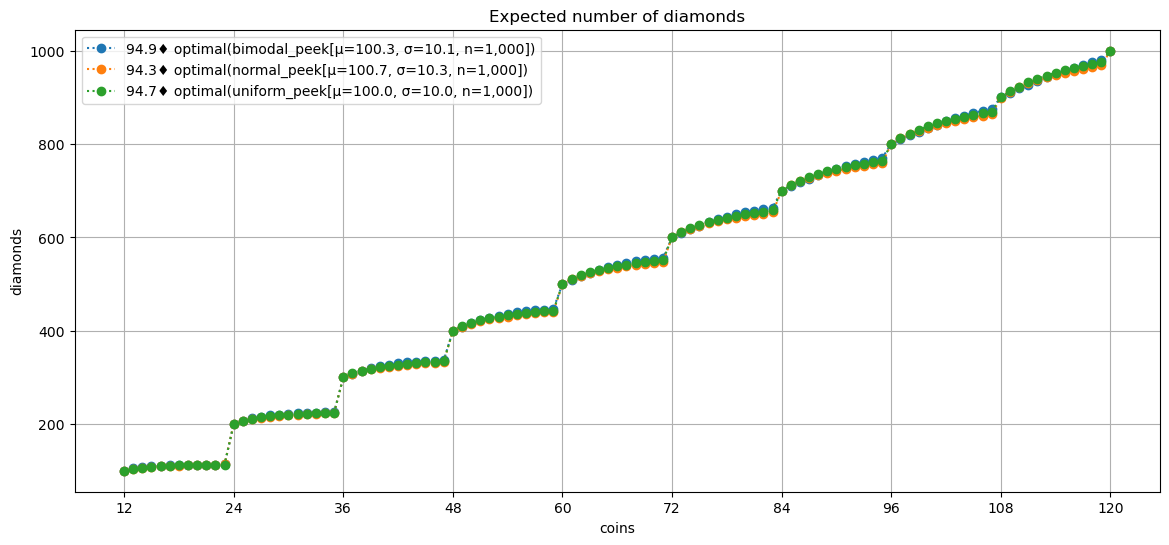

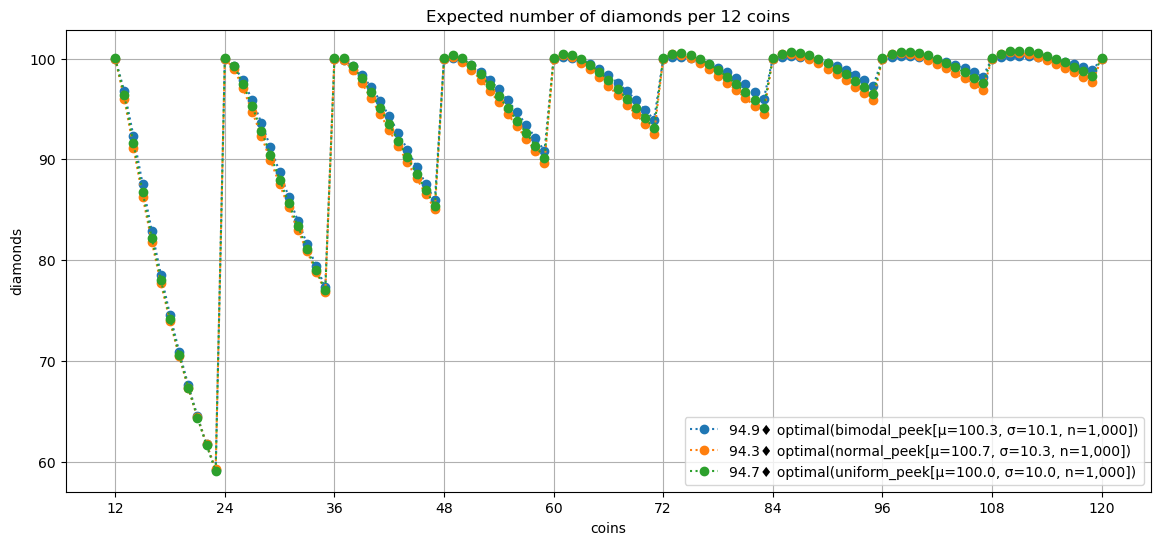

In [28]:
plot_E(shapes3)

Despite the very different shapes, the expected values differ by less than 1%. **I found this very surprising!**

# The effect of stockpile mean

So far, we have looked at stockpiles where the bags have a mean of 100 diamonds. Let's compare that to some stockpiles with a mean of just 10 diamonds (with different standard deviations):

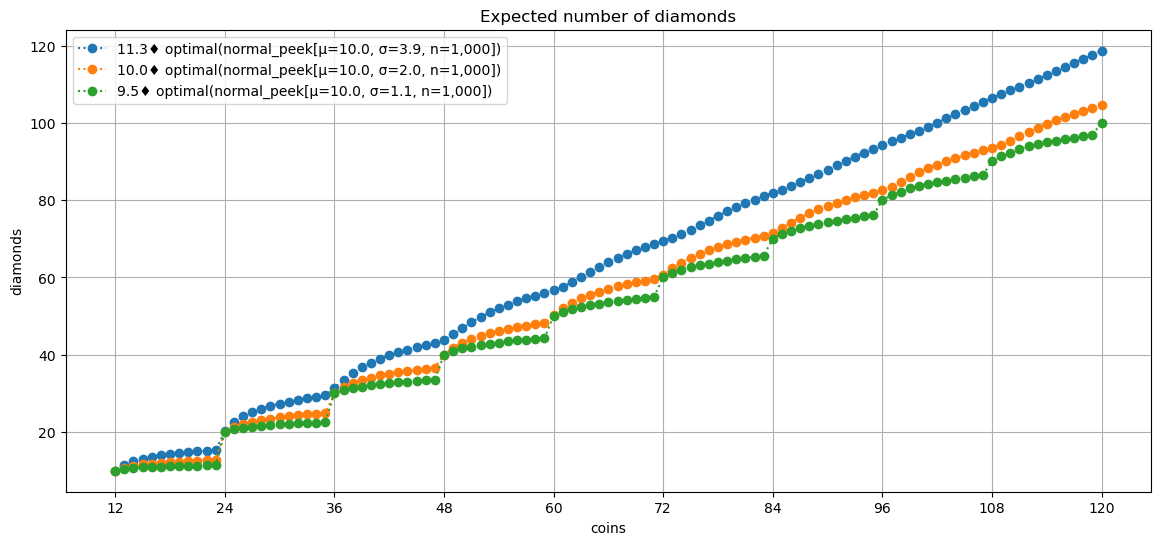

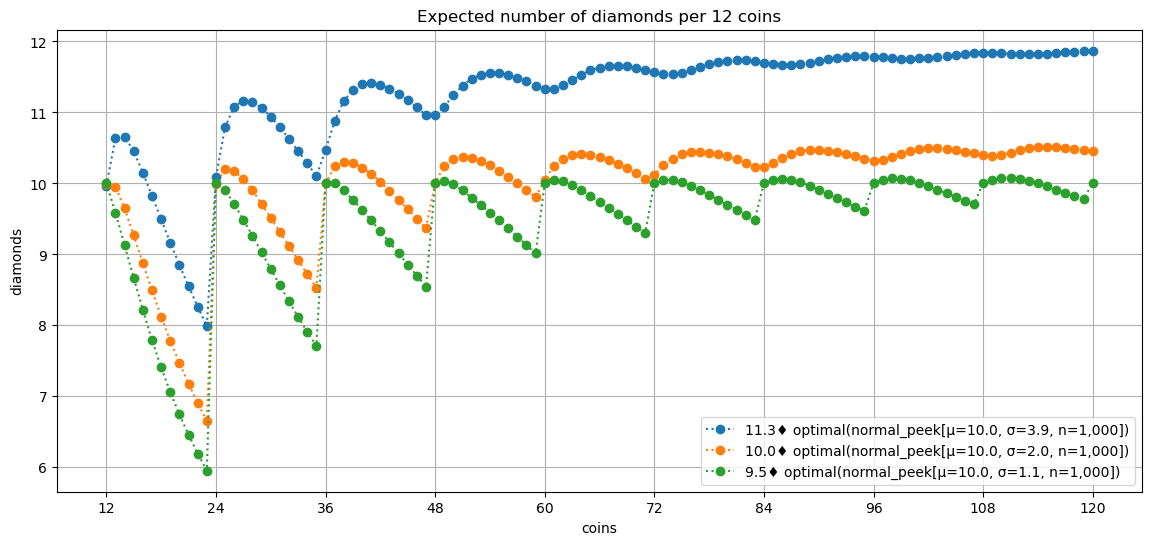

In [29]:
plot_E([normal(4, 10), normal(2, 10), normal(1, 10)])

The results are sinmilar to the results with a mean of 100.

## Comparing cutoff strategies

The cutoff strategy has the advantage of being simple to implement for a human player, but it is not optimal. How close is it? And what is the best cutoff? 

First, we can find the best cutoff for any distribution by exhauastive test and comparison:

In [30]:
@cache
def best_cutoff_strategy(P, coins=COINS, cutoffs=range(50, 150)) -> Strategy:
    """The cutoff strategy that maximizes metric(strategy, P, coins)."""
    strategies = [cutoff_strategy(P, pct/100) for pct in range(101)]
    return max(strategies, key=lambda strategy: metric(strategy, P, coins))

Here are the best cutoff strategies for the `stock10` and `stock33` stockpiles, compared to the optimal strategies for those stockpiles:

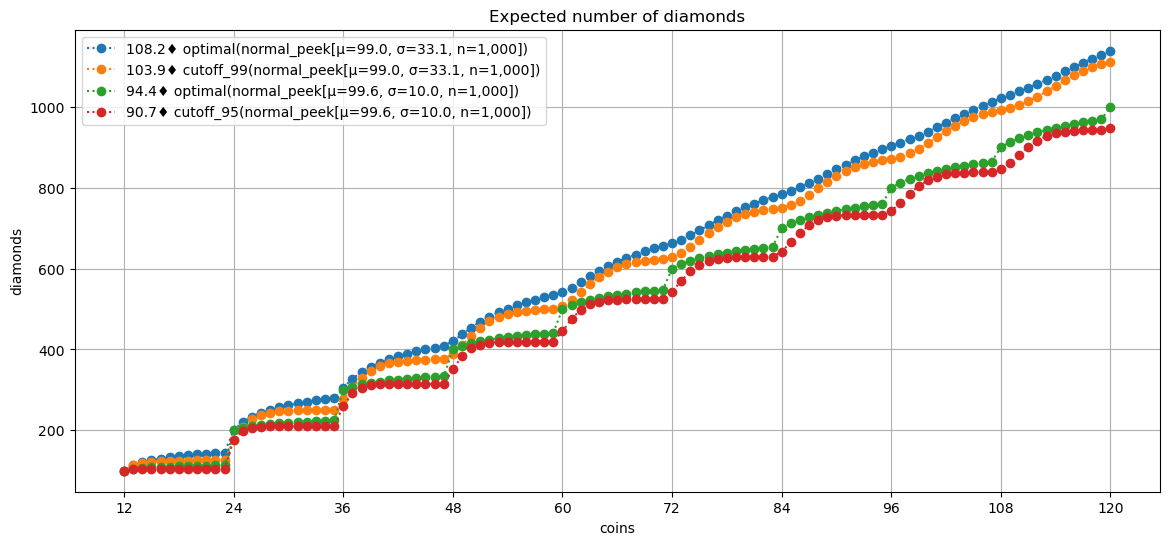

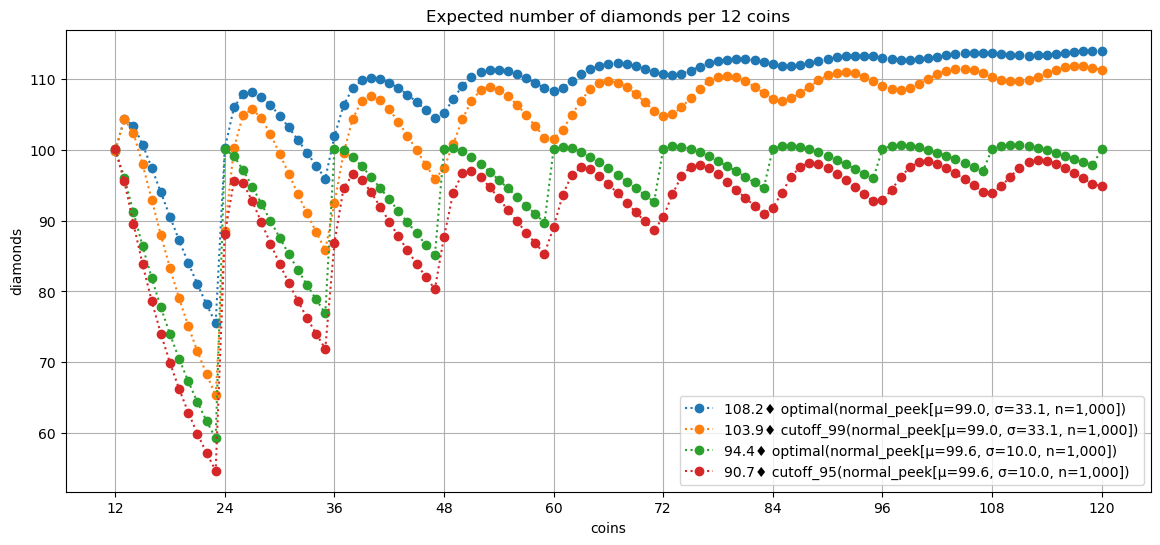

In [31]:
plot_E(stockpiles=[stock33, stock10], strategy_fns=[optimal_strategy, best_cutoff_strategy])

We see that on both stockpiles, the cutoff strategies lag about 4 diamonds behind the optimal strategies. 

Below we can verify that the optimal strategy is indeed better than the cutoff strategy, considering every situation we have looked at so far:

In [32]:
def dominates(S1: Strategy, S2: Strategy, P, coins=COINS) -> bool:
    """Is strategy S1 always as good or better than S2?"""
    return all(E(P, S1, c) >= E(P, S2, c) for c in coins)
    
all(dominates(optimal_strategy(P), best_cutoff_strategy(P), P)
    for P in [stock1, stock10, stock33] + shapes3)

True

# How many peeks are required?

How many bags do we have to peek at to get a good sampling of the stockpile? I arbitrarily set a default of  1,000. But how much worse would we do with fewer peeks? How much better could we do with more peeks? Let's see:

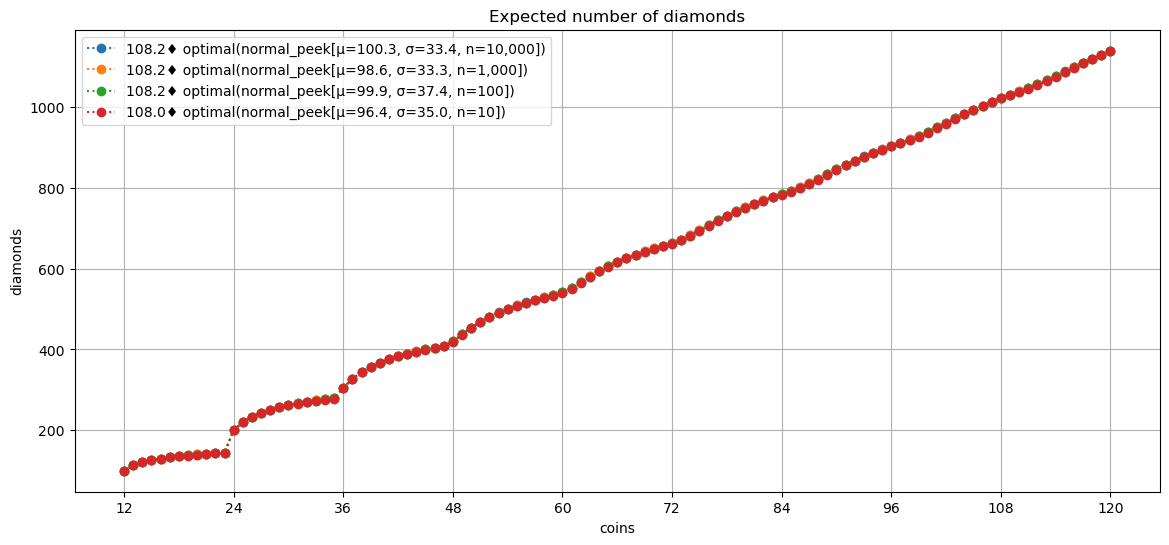

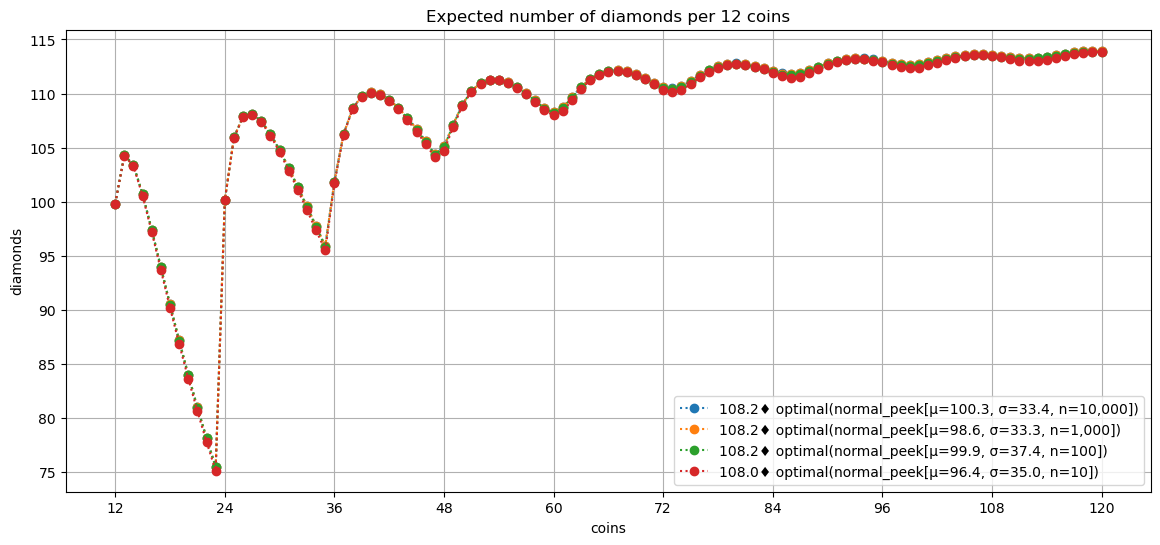

In [33]:
plot_E([stock33], ks=(10_000, 1000, 100, 10))

There is hardly any difference between 10,000 samples and 100 samples! **I found this very surprising!** 

We have to go all the way down to 10 samples before we see a noticable dropoff in expected value. I guess this is saying that 100 samples is enough to get the general idea that the distribution has a mean of somewhere near 100, and a standard deviation somewhere near 33.

Maybe there would be more of a difference if the distribution was harder to predict. Maybe the bimodal distribution?

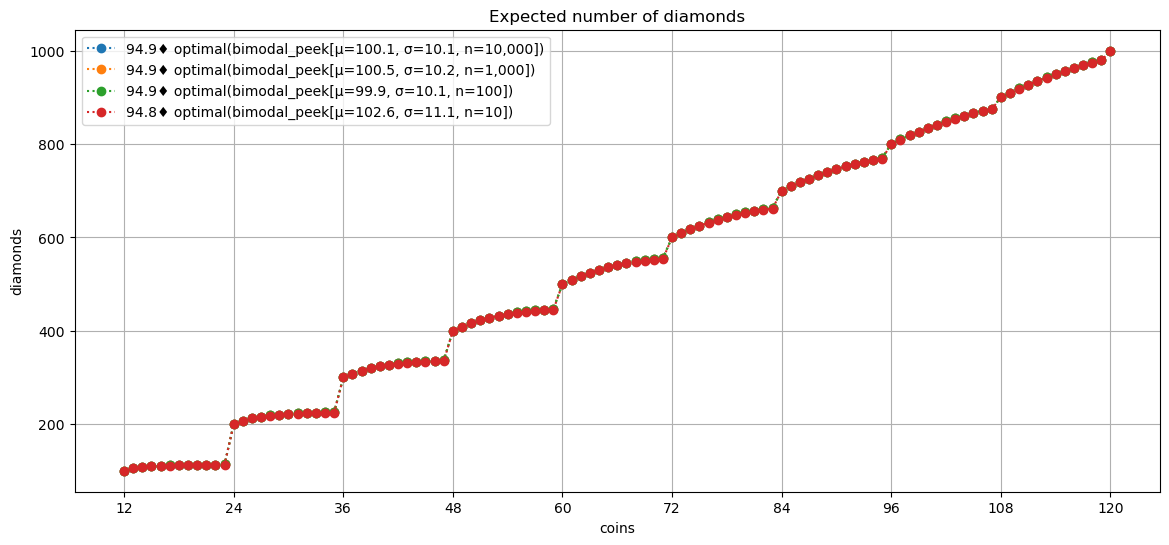

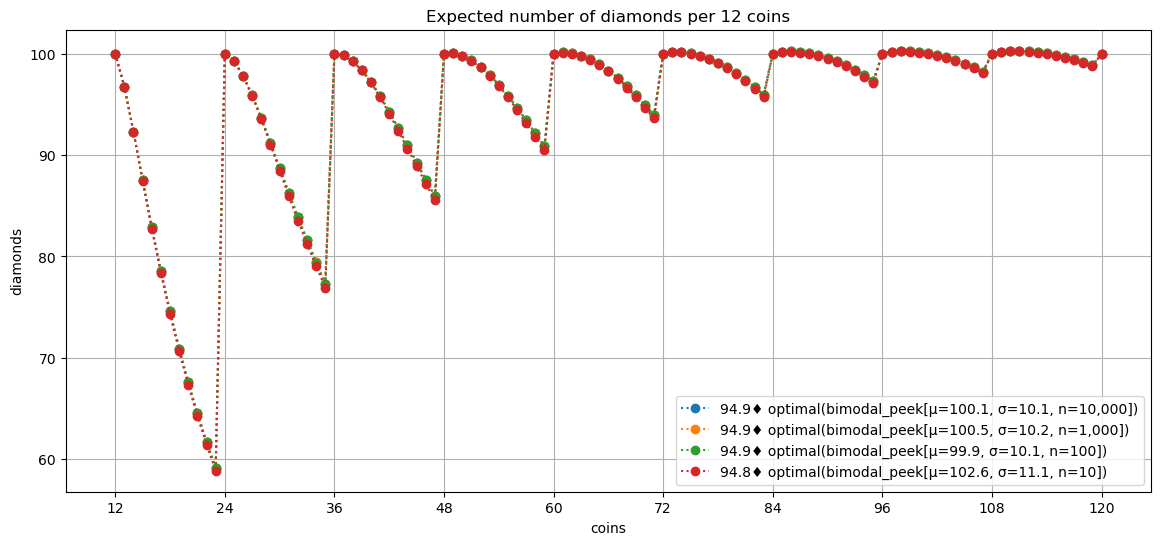

In [34]:
plot_E([bimodal], ks=(10_000, 1000, 100, 10))

Still not much difference. 

Let's try a distribution that is even more skewed: the distribution from Bernoulli's [St. Petersburg Paradox](https://en.wikipedia.org/wiki/St._Petersburg_paradox), in which the the payoff is $2^d$ with probability $2^{-d}$ for all values of $d$ from 1 up to a limit.

In [35]:
def st_pete(limit=14) -> ProbDist:
    """The St. Petersburg distribution."""
    return ProbDist({2 ** i: 2 ** (limit - i) for i in range(1, limit + 1)}, 'St_Pete')

st_pete()

ProbDist({2: 8192,
          4: 4096,
          8: 2048,
          16: 1024,
          32: 512,
          64: 256,
          128: 128,
          256: 64,
          512: 32,
          1024: 16,
          2048: 8,
          4096: 4,
          8192: 2,
          16384: 1})

The mean of this distribution is equal to the `limit` (by default 14):

In [36]:
print(st_pete())

St_Pete[μ=14.0, σ=180.5, n=16,383]


I'll compare 10,000 peeks to two mid-size sets of peeks (101 and 100), and two small sizes (11 and 10). There is a lot of variatioon from one run to the next, so I'll set the random seed to a value that gives a representative result, but you can rerun the cell to get different plots:

In [37]:
random.seed(42)

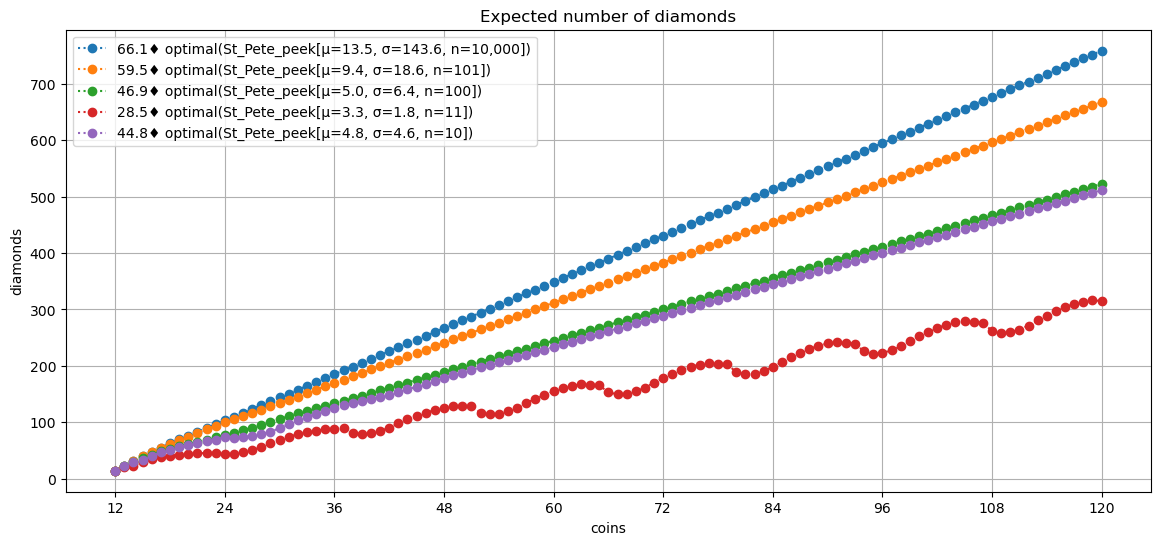

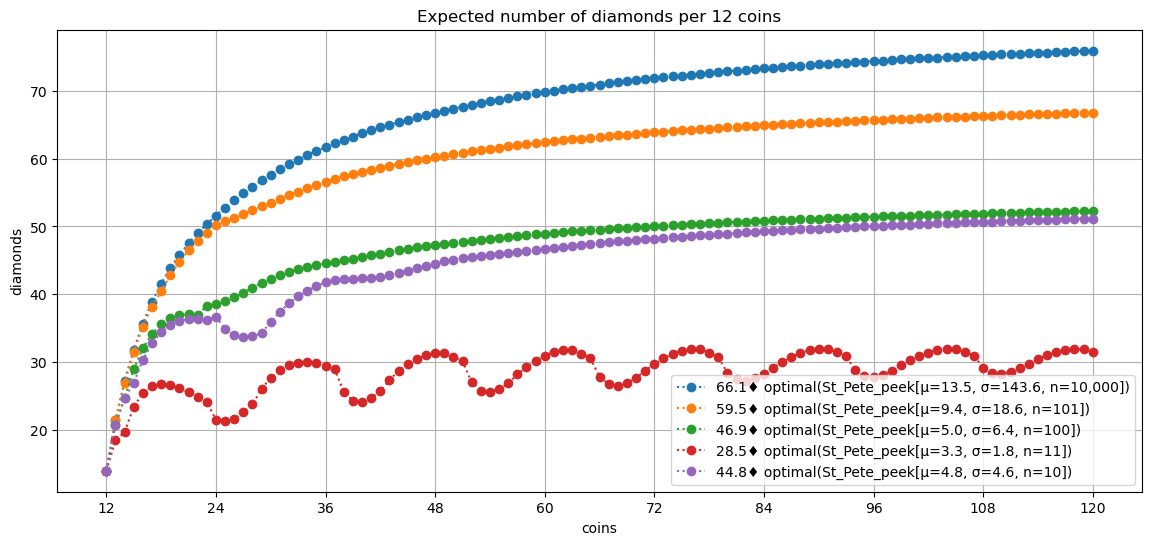

In [38]:
plot_E([st_pete()], ks=(10_000, 101, 100, 11, 10))

The collection of 10,000 peeks gives a very good estimate of the mean and standard deviation, but the smaller samples severely underestimate both the mean and the standard deviation of the distribution, and therefore don't yield as many diamonds.

Let's see what the optimal strategy looks like for this distribution. 

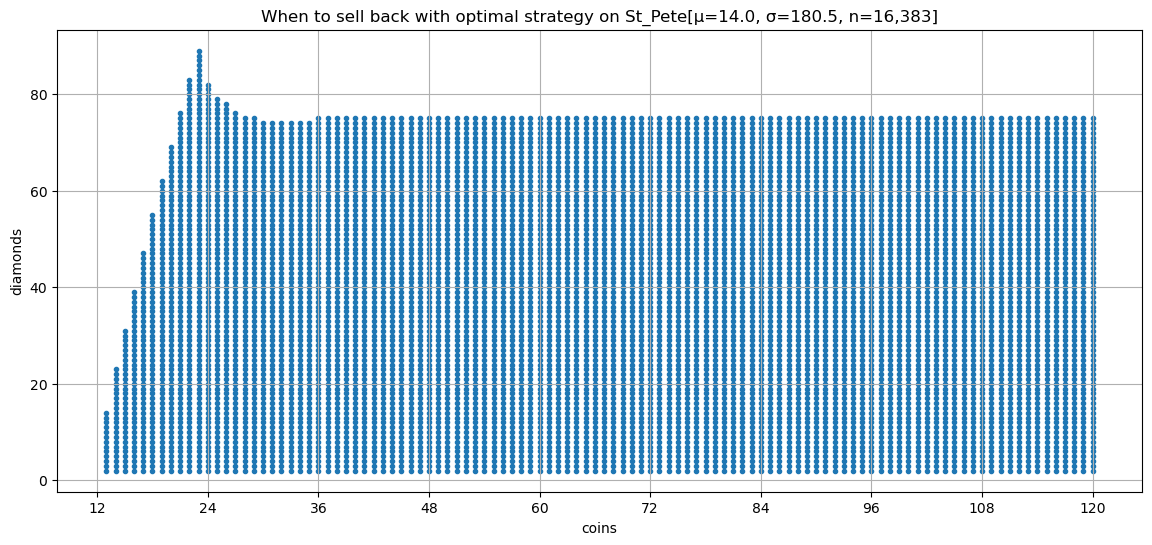

In [39]:
P = st_pete()
plot_strategy(P, optimal_strategy(P)) 

I don't fully understand this plot, but it seems to be saying that up to 24 coins the shape is similar to the optimal strategy on other distributions, but once we get to 36 coins, the strategy is to sell back any bag under about 440 diamonds, regardless of how many coins are left.

# Conclusions

Two main conclusions:

- It is straightforward to implement an optimal strategy for a simple game like this. (For more complex games, it can still be straightforward to *write* the code, but infeasible to *run* it in a reasonable amount of time.) 
- It takes more work to come up with good visualizations to really understand what is going on.